# Проект для «Викишоп» 

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию.

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества F1 не меньше 0.75.

Инструкция по выполнению проекта

    Загрузите и подготовьте данные.
    Обучите разные модели.
    Сделайте выводы.

Для выполнения проекта применять BERT необязательно, но вы можете попробовать.

Описание данных

Данные находятся в файле toxic_comments.csv. Столбец text в нём содержит текст комментария, а toxic — целевой признак.


# 1. Загрузка  и анализ данных

In [2]:
#импорт сторонних библиотек
!pip install torch
!pip install transformers
!pip install warnings
!pip install spacy
!python -m spacy download en_core_web_sm


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 40.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 20.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-04-04 17:02:33.298297: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [3]:
!pip install catboost
!pip install lightgbm
!pip install xgboost
import catboost
from catboost import CatBoostClassifier 
from lightgbm import LGBMClassifier
import spacy 
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.feature_selection import SelectKBest, chi2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 7.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [4]:
#загрузка стандартных библиотек
import numpy as np
import pandas as pd
import torch
import transformers
import warnings
import nltk
from tqdm import notebook
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import re
import nltk
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet
nltk.download('wordnet')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
stopwords_en = stopwords.words('english')
tqdm.pandas()
pd.set_option('display.max_colwidth', -1)
warnings.filterwarnings("ignore")
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import SGDClassifier

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<ipython-input-4-cfa8200632ff>:29: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [6]:
#загрузка датеста
try:
    data = pd.read_csv('/datasets/toxic_comments.csv', index_col=0)
except:
    data = pd.read_csv('toxic_comments.csv', index_col=0)


In [ ]:
data.sample(10)

In [10]:
print('Количество дубликатов в таблице:', data.duplicated().sum())     

Количество дубликатов в таблице: 0


In [11]:
print('Количество пропущенных значений в таблице:', data.isnull().sum().sum ())

Количество пропущенных значений в таблице: 0


0    0.898388
1    0.101612
Name: toxic, dtype: float64


<Axes: >

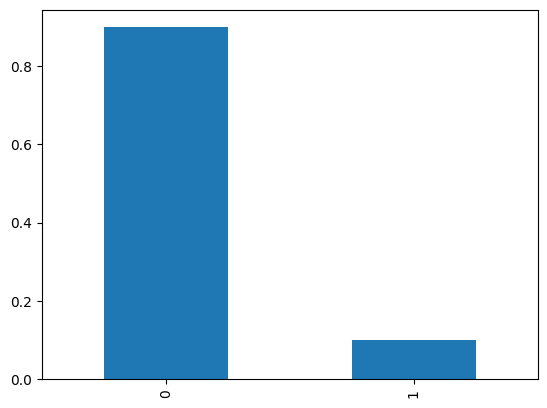

In [12]:
class_frequency = data['toxic'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Исходя из загрузки данных таблицы количество дубликатов равно 0, пропущенные значения также отсутствуют. Данные представлены двумя столбцами 'text'- признак, представленный текстом(комментариями) и целевой признак 'toxic', который представлен бинарной классификацией с сильной несбалансированностью классов. 

# 2. Подготовка данных к обучению

Для сбалансированности выборки я использую функцию 'upsample'. Для лемматизации и очистки комментариев я использую библиотеку spacy

In [13]:
#функция при дисбалансе 
#def upsample(features, target, repeat): 
#features_zeros = features[target == 0]
#features_ones = features[target == 1]
#target_zeros = target[target == 0]  
#target_ones = target[target == 1]
#features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat) 
#target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
#features_upsampled, target_upsampled = shuffle( features_upsampled, target_upsampled, random_state=12345)
#return features_upsampled, target_upsampled

In [7]:
data['text'] = data['text'].str.lower()
data.head(5)

,text,toxic
0,"explanation\nwhy the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27",0
1,"d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) 21:51, january 11, 2016 (utc)",0
2,"hey man, i'm really not trying to edit war. it's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. he seems to care more about the formatting than the actual info.",0
3,"""\nmore\ni can't make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nthere appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up. it's listed in the relevant form eg wikipedia:good_article_nominations#transport """,0
4,"you, sir, are my hero. any chance you remember what page that's on?",0


In [8]:
#применение spacy для лемматизации
def lemma_toxic_spacy(text):
    text = re.sub(r'[\n]', ' ', text)
    doc = nlp(text)
    tokens = [token.lemma_.lower() for token in doc if not token.is_punct and not token.is_digit]
    return ' '.join(tokens)

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [10]:
#разделение на выборки
features=data['text']
target=data['toxic']

In [18]:
#проверка лемматизации spacy
sentence_1 = "The parallel coordinates plot displays the values of the hyperparameters on different columns while the performance metric is color coded"
sentence_2 = " It is possible to select a range of results by clicking and holding on any axis of the parallel coordinate plot"
test_text = pd.DataFrame([sentence_1, sentence_2], columns=['texts'])

test_text['texts'].apply(lemma_toxic_spacy)


0    the parallel coordinate plot display the value of the hyperparameter on different column while the performance metric be color code
1      it be possible to select a range of result by click and hold on any axis of the parallel coordinate plot                         
Name: texts, dtype: object

In [11]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
!pip install pandas jupyter pandarallel requests tqdm
from pandarallel import pandarallel 
tqdm.pandas(desc="progress")
pandarallel.initialize(progress_bar = True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.2/121.2 KB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 KB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.3 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.4-py3-none-any.whl size=16677 sha256=d1d2ca258879075f6b2f17dfafce33050ca621285b8f8f9792a1b48057d21688
  Stored in directory: /root/.cache/pip/wheels/41/01/29/deaa71fe596f8d857e57c4fb388db8861e23e6ed0b03204dcb
Successfully built pandarallel
INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
 spacy_lemma=features.parallel_apply(lemma_toxic_spacy)

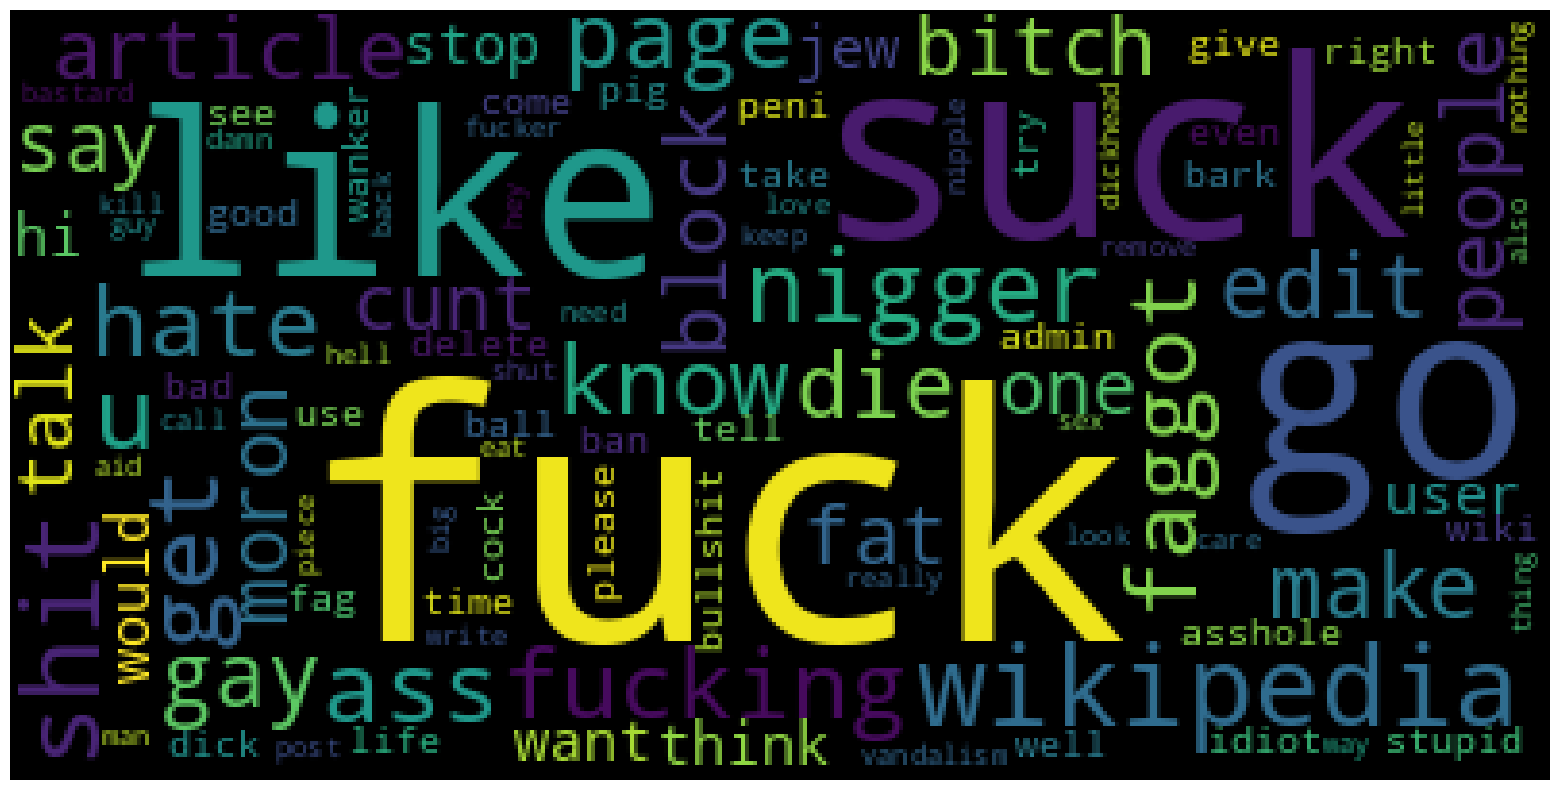

In [22]:
#Облако слов с токсичными комментариями
from wordcloud import WordCloud
data_negative = spacy_lemma[target == 1]
text_cloud = ' '.join(data_negative)
cloud = WordCloud(stopwords=stopwords_en, max_words=100, collocations=False).generate(text_cloud)
plt.figure(figsize=(20,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()   

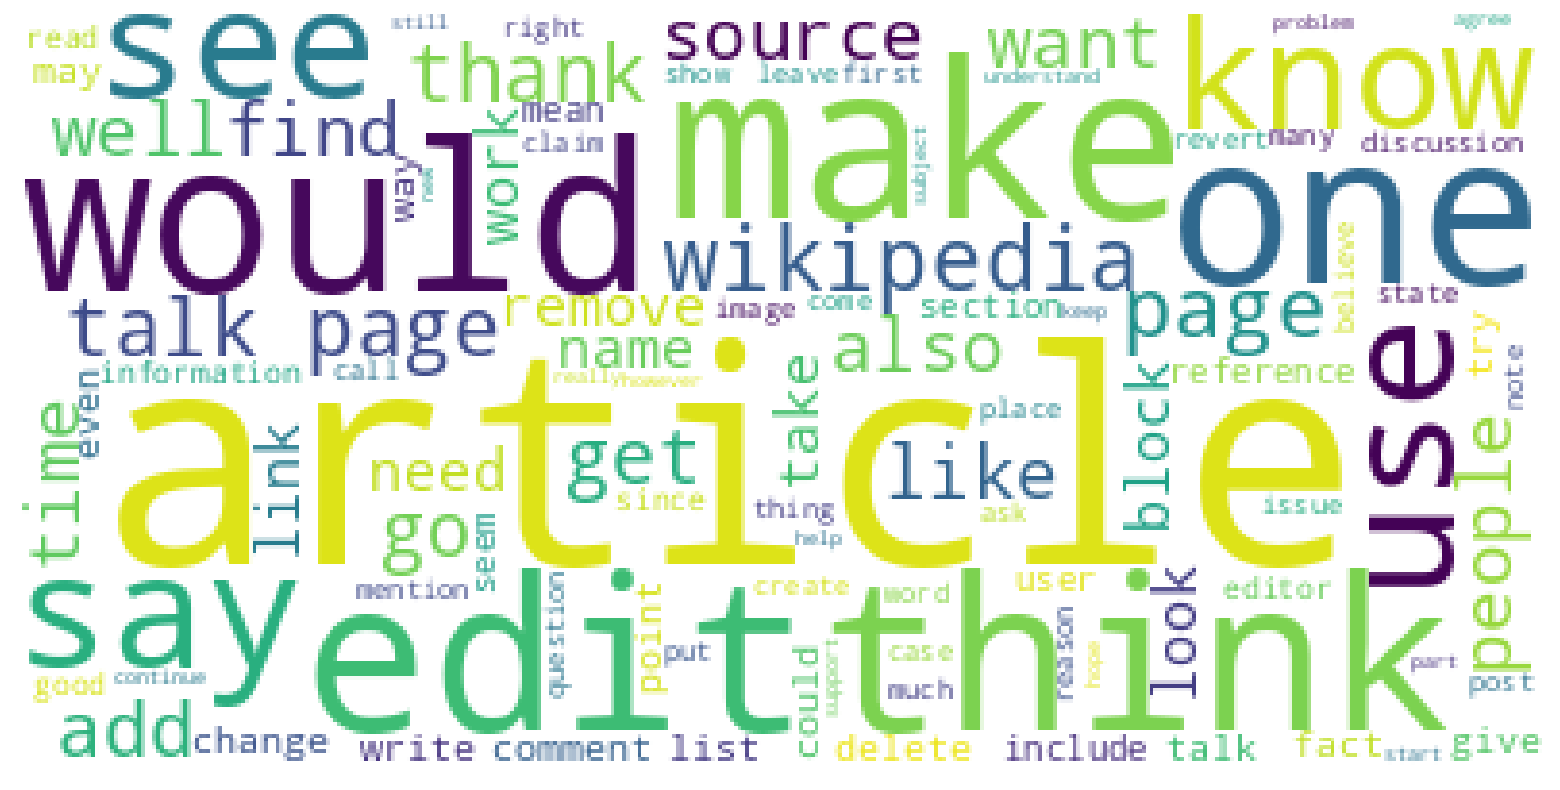

In [23]:
#Облако слов с нетоксинч=ыми комментариями
data_positive = spacy_lemma[target == 0]
text_cloud = ' '.join(data_positive)
cloud = WordCloud(stopwords=stopwords_en, max_words=100, background_color='white').generate(text_cloud)
plt.figure(figsize=(20,10))
plt.imshow(cloud)
plt.axis('off')
plt.show()   

In [14]:
# Разделение на выборки
features_train,features_test,target_train,target_test=train_test_split(spacy_lemma,target,test_size=0.3,random_state=12345)

В предобработке данных с помощью функции 'upsample' я использовала для тго, чтобы избавиться от сильного дисбаланса классов. Далее был использован  spacy для лемматизации и очистки комментариев. Были загружены стоп слова и переведы в векторный вид TL-IDF тестовая и обучающая выборки.
Столбец, содержащий комментарии, был приведен к нижнему регистру. Для обработки данных перед обучением моделей был использован spacy для лемматизации и очистки комментариев. Также после лемматизации был использовано Облако слов для графического представления слов наиболее встречающихся в токсичных и нетоксичных комментариях.

# 3. Обучение моделей

# 3.1 Логисическая регрессия

In [25]:
Pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000)),
    ('LogisticRegression', LogisticRegression (class_weight='balanced', max_iter=1000, random_state=12345))
])    
logrf_cv = GridSearchCV(estimator=Pipe,
                         param_grid={},
                         scoring='f1',
                         n_jobs=-1
                        )
logrf_cv.fit(features_train, target_train)
print('f1', logrf_cv.best_score_)    

f1 0.7236592871481713


На тренировочной выборке модель "Логистическая регрессия" показала результат 0.7236 

# 3.2 LightGBM Classifier

In [26]:
Pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000)),
    ('LGBMClassifier', LGBMClassifier (class_weight='balanced', random_state=12345))
])   
lgbmccl_cv = GridSearchCV(estimator=Pipe,
                         param_grid={},
                         scoring='f1',
                         n_jobs=-1
                        )
lgbmccl_cv.fit(features_train, target_train)
print('f1', lgbmccl_cv.best_score_)    

f1 0.7272431033859723


На тренировочной выборке модель "LightGBM Classifier" показала результат  0.7272

# 3.3 SGDClassifier

In [27]:
Pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000)),
    ('sgd_clf', SGDClassifier(penalty='elasticnet', class_weight='balanced', random_state=12345))
])   
sgd_cv = GridSearchCV(estimator=Pipe,
                         param_grid={},
                         scoring='f1',
                         n_jobs=-1
                        )
sgd_cv.fit(features_train, target_train)
print('f1', sgd_cv.best_score_) 

f1 0.7179941275767441


На тренировочной выборке модель "SGDClassifier" показала результат 0.7179

# 3.4 RidgeClassifier

In [28]:
Pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000)),
    ('RidgeClassifier', RidgeClassifier(class_weight='balanced', random_state=12345))
])   
rid_cv = GridSearchCV(estimator=Pipe,
                         param_grid={},
                         scoring='f1',
                         n_jobs=-1
                        )
rid_cv.fit(features_train, target_train)
print('f1', rid_cv.best_score_) 

f1 0.6917919507158821


На тренировочной выборке модель "SGDClassifier" показала результат 0.6918


# 3.6 CatBoostClassifier

In [15]:
Pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000)),
    ('CatBoostClassifier', CatBoostClassifier(random_state=12345))
])   
cat_cv = GridSearchCV(estimator=Pipe,
                         param_grid={},
                         scoring='f1',
                         n_jobs=-1
                        )
cat_cv.fit(features_train, target_train)
print('f1:', cat_cv.best_score_) 

Learning rate set to 0.077113
0:	learn: 0.6121186	total: 110ms	remaining: 1m 50s
1:	learn: 0.5448409	total: 170ms	remaining: 1m 24s
2:	learn: 0.4899904	total: 229ms	remaining: 1m 15s
3:	learn: 0.4440680	total: 287ms	remaining: 1m 11s
4:	learn: 0.4084010	total: 353ms	remaining: 1m 10s
5:	learn: 0.3777831	total: 412ms	remaining: 1m 8s
6:	learn: 0.3530184	total: 472ms	remaining: 1m 6s
7:	learn: 0.3310401	total: 530ms	remaining: 1m 5s
8:	learn: 0.3141783	total: 593ms	remaining: 1m 5s
9:	learn: 0.3002536	total: 653ms	remaining: 1m 4s
10:	learn: 0.2885153	total: 719ms	remaining: 1m 4s
11:	learn: 0.2788879	total: 777ms	remaining: 1m 4s
12:	learn: 0.2704405	total: 841ms	remaining: 1m 3s
13:	learn: 0.2634639	total: 903ms	remaining: 1m 3s
14:	learn: 0.2575642	total: 963ms	remaining: 1m 3s
15:	learn: 0.2507708	total: 1.04s	remaining: 1m 4s
16:	learn: 0.2462249	total: 1.12s	remaining: 1m 4s
17:	learn: 0.2423799	total: 1.18s	remaining: 1m 4s
18:	learn: 0.2388398	total: 1.23s	remaining: 1m 3s
19:	le

На тренировочной выборке модель "CatBoostClassifier" показала результат 0.75

In [43]:
index = ['Логистическая регрессия',
         'LightGBM Classifier',
         'SGDClassifier',
         'RidgeClassifier',
         'CatBoostClassifier']
MODEL = {'F1 на тренировочной выборке': [0.72,
                                         0.73,
                                         0.72,
                                         0.69,
                                         0.75]
         }
MODEL = pd.DataFrame(data=MODEL, index=index)  

In [44]:
MODEL
MODEL.style\
    .background_gradient(cmap='coolwarm')

,F1 на тренировочной выборке
Логистическая регрессия,0.720000
LightGBM Classifier,0.730000
SGDClassifier,0.720000
RidgeClassifier,0.690000
CatBoostClassifier,0.750000


Были представлены модели для обучения: 'Логистическая регрессия', 'LGBMClassifier', 'SGDClassifier','RidgeClassifier','CatBoostClassifier'. Наилучшую метрику f1 показал Catboost 0.75

# 4. Тестирование на лучшей модели

In [26]:
pipe = Pipeline([
    ('vec', FeatureUnion([
        ('bow_words', CountVectorizer(ngram_range=(1,2), stop_words=stopwords_en)),
        ('tfidf', TfidfVectorizer(ngram_range=(2,2), stop_words=stopwords_en))
    ])),
    ('chi2', SelectKBest(chi2, k=1000))    
])
features_train_transformed = pipe.fit_transform(features_train, target_train)
features_test_transformed = pipe.transform(features_test)
model = CatBoostClassifier().fit(features_train_transformed, target_train)
predictions = model.predict(features_test_transformed)                               
score = f1_score(target_test, predictions)
print('f1 на тестовой выборке равна: {:.2f} '.format(score)) 


Learning rate set to 0.077113
0:	learn: 0.6148665	total: 60.5ms	remaining: 1m
1:	learn: 0.5506954	total: 118ms	remaining: 58.7s
2:	learn: 0.4957428	total: 179ms	remaining: 59.3s
3:	learn: 0.4494505	total: 240ms	remaining: 59.8s
4:	learn: 0.4128929	total: 305ms	remaining: 1m
5:	learn: 0.3828354	total: 366ms	remaining: 1m
6:	learn: 0.3569765	total: 435ms	remaining: 1m 1s
7:	learn: 0.3362138	total: 523ms	remaining: 1m 4s
8:	learn: 0.3189948	total: 597ms	remaining: 1m 5s
9:	learn: 0.3044548	total: 657ms	remaining: 1m 5s
10:	learn: 0.2910131	total: 725ms	remaining: 1m 5s
11:	learn: 0.2809508	total: 786ms	remaining: 1m 4s
12:	learn: 0.2715640	total: 852ms	remaining: 1m 4s
13:	learn: 0.2643931	total: 914ms	remaining: 1m 4s
14:	learn: 0.2582870	total: 977ms	remaining: 1m 4s
15:	learn: 0.2528162	total: 1.04s	remaining: 1m 3s
16:	learn: 0.2473414	total: 1.1s	remaining: 1m 3s
17:	learn: 0.2434938	total: 1.16s	remaining: 1m 3s
18:	learn: 0.2393607	total: 1.23s	remaining: 1m 3s
19:	learn: 0.2363891

На тестовой выборке модель CatBoost показала результат 0.75. 

# Вывод

Исходя из загрузки данных таблицы количество дубликатов равно 0, пропущенные значения также отсутствуют. Данные представлены двумя столбцами 'text'- признак, представленный текстом(комментариями) и целевой признак 'toxic', который представлен бинарной классификацией с сильной несбалансированностью классов.

 Столбец, содержащий комментарии, был приведен к нижнему регистру. Для обработки данных перед обучением моделей был использован spacy для лемматизации и очистки комментариев. Также после лемматизации был использовано Облако слов для графического представления слов наиболее встречающихся в токсичных и нетоксичных комментариях.
 
 Были представлены модели для обучения: 'Логистическая регрессия', 'LGBMClassifier', 'SGDClassifier','RidgeClassifier','CatBoostClassifier'. Наилучшую метрику f1 показал Catboost 0.75
На тестовой выборке модель CatBoost показала результат 0.75. 
